In [1]:
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import fetch_openml
import os

### Prepare data

In [2]:
from collections import Counter
import pickle

with open("data_cobot_new/test_new_2.pickle", "rb") as f:
    data = pickle.load(f)

labels = data["label"]

print("num samples:", len(labels))
print("num classes:", len(set(labels)))
print("class distribution:", Counter(labels))


num samples: 1330
num classes: 19
class distribution: Counter({14: 77, 17: 75, 16: 74, 3: 72, 6: 72, 1: 72, 11: 71, 4: 71, 5: 71, 7: 71, 9: 71, 12: 71, 2: 71, 0: 71, 18: 70, 13: 70, 8: 69, 10: 64, 15: 47})


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import (
    Input,
    Lambda,
    Reshape,
    Conv1D,
    BatchNormalization,
    LeakyReLU,
    SpatialDropout1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    concatenate
)

from utils import *
from tensorflow.keras.models import Model
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
import random
import tqdm

In [4]:
random.seed(123)

class Config():
    def __init__(self):
        self.frame_l = 60 # the length of frames
        self.joint_n = 48 # the number of joints
        self.joint_d = 3 # the dimension of joints
        self.clc_num = 19 # the number of class
        self.feat_d = 1128
        self.filters = 16
        self.data_dir = 'data_cobot_new'
C = Config()

In [5]:
def data_generator(T,C,le):
    X_0 = []
    X_1 = []
    Y = []
    for i in tqdm(range(len(T['pose']))):
        p = np.copy(T['pose'][i])
        p = zoom(p,target_l=C.frame_l,joints_num=C.joint_n,joints_dim=C.joint_d)

        label = np.zeros(C.clc_num)
        label[le.transform(T['label'])[i]] = 1

        M = get_CG(p,C)

        X_0.append(M)
        X_1.append(p)
        Y.append(label)

    X_0 = np.stack(X_0)
    X_1 = np.stack(X_1)
    Y = np.stack(Y)
    return X_0,X_1,Y

In [6]:
import pickle
from tqdm import tqdm
Train = pickle.load(open(C.data_dir+"/train_new_2.pickle", "rb"))
Test = pickle.load(open(C.data_dir+"/test_new_2.pickle", "rb"))

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(Train['label'])

X_0,X_1,Y = data_generator(Train,C,le)
X_test_0,X_test_1,Y_test = data_generator(Test,C,le)


100%|██████████| 1330/1330 [00:56<00:00, 23.47it/s]


### Build model

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Lambda, Reshape
from tensorflow.keras.layers import (
    Input,
    Lambda,
    Reshape,
    Conv1D,
    BatchNormalization,
    LeakyReLU,
    SpatialDropout1D,
    MaxPooling1D,
    GlobalMaxPooling1D,
    Dense,
    Dropout,
    concatenate
)
from tensorflow.keras.models import Model

# ----------------------------
# 1. Pose Difference Functions with Explicit Output Shapes
# ----------------------------

import tensorflow as tf

# Decorate your custom functions so that they are registered and can be found during deserialization.

@tf.keras.utils.register_keras_serializable()
def poses_diff(x):
    """
    Compute differences between consecutive frames in x and then use
    tf.image.resize to “restore” the original frame count.

    Assumes x has shape: (batch, frames, joints, dims)
    """
    orig_frames = tf.shape(x)[1]  # e.g., 32
    joint_n = tf.shape(x)[2]      # e.g., 22

    # Compute differences along the frame axis.
    diff = x[:, 1:, ...] - x[:, :-1, ...]

    # Resize the differences back to have the original number of frames.
    resized = tf.image.resize(diff, size=[orig_frames, joint_n])
    return resized

@tf.keras.utils.register_keras_serializable()
def poses_diff_func(x):
    # Simply a wrapper around poses_diff.
    return poses_diff(x)

def poses_diff_output_shape(input_shape):
    # Assuming the input shape is (batch, frames, joints, dims) and we intend to recover it.
    return input_shape


@tf.keras.utils.register_keras_serializable()
def sample_every_2(x):
    """
    Sample every 2nd frame from the input tensor.
    """
    return x[:, ::2, ...]

def sample_every_2_output_shape(input_shape):
    # Given input shape (batch, frames, joints, dims), return (batch, frames//2, joints, dims)
    batch = input_shape[0]
    frames = input_shape[1]
    joints = input_shape[2]
    dims = input_shape[3]
    return (batch, frames // 2, joints, dims)


def pose_motion(P, frame_l):
    """
    For a pose input P (shape: (batch, frame_l, joint_n, joint_d)),
    compute two kinds of differences:
      - Slow differences: computed on the full input.
      - Fast differences: computed on every 2nd frame.

    Then reshape the outputs so that the spatial dimensions are flattened.
    """
    # Slow branch using our registered function:
    P_diff_slow = Lambda(poses_diff_func, output_shape=poses_diff_output_shape)(P)
    P_diff_slow = Reshape((frame_l, -1))(P_diff_slow)

    # Fast branch:
    P_fast = Lambda(sample_every_2, output_shape=sample_every_2_output_shape)(P)
    P_diff_fast = Lambda(poses_diff_func, output_shape=poses_diff_output_shape)(P_fast)
    P_diff_fast = Reshape((frame_l // 2, -1))(P_diff_fast)

    return P_diff_slow, P_diff_fast

# ----------------------------
# 2. Convolutional and Dense Helper Blocks
# ----------------------------

def c1D(x, filters, kernel):
    x = Conv1D(filters, kernel_size=kernel, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

def block(x, filters):
    x = c1D(x, filters, 3)
    x = c1D(x, filters, 3)
    return x

def d1D(x, filters):
    x = Dense(filters, use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)
    return x

# ----------------------------
# 3. Build the Feature Model (FM)
# ----------------------------

def build_FM(frame_l=32, joint_n=22, joint_d=2, feat_d=231, filters=16):
    # Define inputs:
    M = Input(shape=(frame_l, feat_d))
    P = Input(shape=(frame_l, joint_n, joint_d))

    # Compute pose differences:
    diff_slow, diff_fast = pose_motion(P, frame_l)

    # Process the M input with a series of 1D convolutions.
    x = c1D(M, filters * 2, 1)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 3)
    x = SpatialDropout1D(0.1)(x)
    x = c1D(x, filters, 1)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.1)(x)

    # Process slow pose differences.
    x_d_slow = c1D(diff_slow, filters * 2, 1)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow, filters, 3)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)
    x_d_slow = c1D(x_d_slow, filters, 1)
    x_d_slow = MaxPooling1D(pool_size=2)(x_d_slow)
    x_d_slow = SpatialDropout1D(0.1)(x_d_slow)

    # Process fast pose differences.
    x_d_fast = c1D(diff_fast, filters * 2, 1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast, filters, 3)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)
    x_d_fast = c1D(x_d_fast, filters, 1)
    x_d_fast = SpatialDropout1D(0.1)(x_d_fast)

    # Concatenate all three processed branches.
    x = concatenate([x, x_d_slow, x_d_fast])
    x = block(x, filters * 2)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x, filters * 4)
    x = MaxPooling1D(pool_size=2)(x)
    x = SpatialDropout1D(0.1)(x)

    x = block(x, filters * 8)
    x = SpatialDropout1D(0.1)(x)

    return Model(inputs=[M, P], outputs=x)

# ----------------------------
# 4. Build the Final DD-Net Model
# ----------------------------

def build_DD_Net(C):
    """
    Assumes that C is an object or namespace with the following attributes:
      - C.frame_l: number of frames
      - C.feat_d: dimensionality of the M input features
      - C.joint_n: number of joints
      - C.joint_d: joint dimension (e.g., 2)
      - C.filters: base number of filters for the conv layers
      - C.clc_num: number of output classes
    """
    M = Input(name='M', shape=(C.frame_l, C.feat_d))
    P = Input(name='P', shape=(C.frame_l, C.joint_n, C.joint_d))

    FM = build_FM(C.frame_l, C.joint_n, C.joint_d, C.feat_d, C.filters)
    x = FM([M, P])

    x = GlobalMaxPooling1D()(x)
    x = d1D(x, 128)
    x = Dropout(0.5)(x)
    x = d1D(x, 128)
    x = Dropout(0.5)(x)
    x = Dense(C.clc_num, activation='softmax')(x)

    model = Model(inputs=[M, P], outputs=x)
    return model


In [8]:
DD_Net = build_DD_Net(C)
DD_Net.summary()

C:\Users\Nguyen Ha Anh\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ M (InputLayer)      │ (None, 60, 1128)  │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ P (InputLayer)      │ (None, 60, 48, 3) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 7, 128)    │    153,088 │ M[0][0], P[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 128)       │          0 │ functional[0][0]  │
│ (GlobalMaxPooling1… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,384 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_15      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ leaky_re_lu_15[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 128)       │     16,384 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_16      │ (None, 128)       │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ leaky_re_lu_16[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 19)        │      2,451 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 189,331 (739.57 KB)

 Trainable params: 187,539 (732.57 KB)

 Non-trainable params: 1,792 (7.00 KB)

### Load model & Test

In [11]:
# save model
model_path = r'D:\HaAnh\AimCLR-v2-main\DD_Net_cobo_v1_80%_best.keras'


In [12]:
from tensorflow.keras.models import load_model
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix

custom_objects = {
    'poses_diff_func': poses_diff_func,
    'poses_diff_output_shape': poses_diff_output_shape,
    'sample_every_2': sample_every_2,
    'sample_every_2_output_shape': sample_every_2_output_shape,
}

model = load_model(model_path, custom_objects=custom_objects)

y_prob = model.predict([X_test_0, X_test_1])      # shape (N, C)
y_pred = np.argmax(y_prob, axis=1)
y_test = np.argmax(Y_test, axis=1)

# ===== Top-1 =====
acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print("Top-1 Test accuracy:", acc)
print("Confusion matrix:\n", cm)

# ===== Top-5 =====
# lấy top-5 indices trong mỗi prediction
top5 = np.argsort(y_prob, axis=1)[:, -5:]

# check xem label thật có nằm trong top-5 không
top5_hits = [y_test[i] in top5[i] for i in range(len(y_test))]
top5_acc = np.mean(top5_hits)

print("Top-5 Test accuracy:", top5_acc)


C:\Users\Nguyen Ha Anh\AppData\Roaming\Python\Python312\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['M', 'P']. Received: the structure of inputs=('*', '*')
  warnings.warn(


42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 63ms/step
Top-1 Test accuracy: 0.7661654135338346
Confusion matrix:
 [[62  0  1  0  0  8  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 71  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 70  1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1 68  0  0  0  0  0  0  0  0  0  2  0  0  0  0  1]
 [ 0  0  1  0 68  1  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [14  0  1  0  0 55  0  1  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  0 68  0  0  2  0  1  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  0 67  0  0  0  2  0  0  0  0  0  0  0]
 [ 0  1  0  1  0  0  0  1 15  1  0  0  0 47  0  0  0  0  3]
 [ 0  0  0  3  0  0  0  0  0 44  1  5  8 10  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  3  1  1 58  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0 15  1 26 27  0  0  0  0  0  0]
 [ 0  0  1  1  0  0  0  0  0  1  2  1 65  0  0  0  0  0  0]
 [ 0  0  0  0  1  0  0  0  8  5  0  0  0 56  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  0 75  0  1  0  0]
 

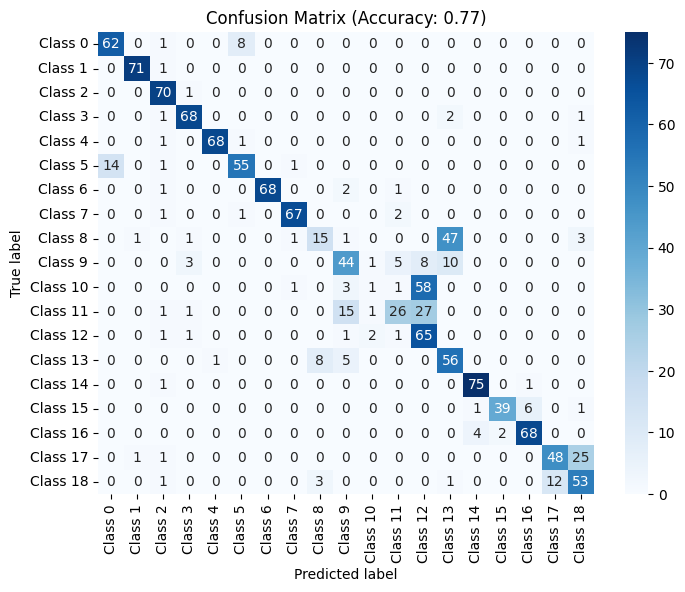

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
# Vẽ confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=True,
            xticklabels=[f"Class {i}" for i in range(cm.shape[0])],
            yticklabels=[f"Class {i}" for i in range(cm.shape[0])])
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.title(f'Confusion Matrix (Accuracy: {acc:.2f})')
plt.show()